In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io

from itertools import chain
from PIL import Image
from scipy import stats

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df["path"] = sample_df["Image Index"].map(sample_df_paths.get)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4407,00021782_027.png,Pneumothorax,27,21782,031Y,F,AP,3056,2544,0.139,0.139,/data/images_010/images/00021782_027.png
3934,00019406_005.png,No Finding,5,19406,055Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019406_005.png
1282,00006727_001.png,Edema|Effusion|Mass,1,6727,037Y,F,PA,2048,2500,0.171,0.171,/data/images_004/images/00006727_001.png


In [4]:
print(len(all_xray_df))
all_xray_df.sample(10)

112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
18261,00004858_075.png,No Finding,75,4858,39,F,PA,2814,2765,0.143,0.143,NaN
62050,00015355_012.png,No Finding,12,15355,70,M,PA,2992,2991,0.143,0.143,NaN
38251,00010007_170.png,Pleural_Thickening,170,10007,59,M,AP,2500,2048,0.168,0.168,NaN
56524,00014060_000.png,Fibrosis|Nodule,0,14060,59,F,PA,2992,2991,0.143,0.143,NaN
45522,00011683_006.png,Atelectasis|Effusion|Emphysema,6,11683,55,F,PA,2992,2991,0.143,0.143,NaN
67059,00016571_003.png,No Finding,3,16571,75,M,PA,2500,2048,0.168,0.168,NaN
40632,00010548_010.png,No Finding,10,10548,66,F,PA,2410,2991,0.143,0.143,NaN
90463,00022520_001.png,Infiltration|Nodule,1,22520,29,M,PA,2992,2991,0.143,0.143,NaN
33791,00008855_007.png,No Finding,7,8855,21,M,AP,2500,2048,0.168,0.168,NaN
33066,00008669_005.png,No Finding,5,8669,58,F,PA,2048,2500,0.168,0.168,NaN


In [5]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [6]:
all_xray_df['Unnamed: 11'].value_counts()

Series([], Name: Unnamed: 11, dtype: int64)

In [7]:
# Drop NaN column Unnamed: 11
all_xray_df = all_xray_df.drop(columns = ['Unnamed: 11'])
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [8]:
# Check for outliers
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


In [9]:
# Drop outlier data with Patient Age > 110
all_xray_df[all_xray_df['Patient Age'] > 110]
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 110]
len(all_xray_df)

112104

In [10]:
## EDA
# Check gender distribution
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

(array([9.7022e+04, 9.1300e+03, 3.3630e+03, 1.3810e+03, 5.4700e+02,
        3.1600e+02, 1.6600e+02, 9.5000e+01, 5.7000e+01, 2.7000e+01]),
 array([  0. ,  18.3,  36.6,  54.9,  73.2,  91.5, 109.8, 128.1, 146.4,
        164.7, 183. ]),
 <a list of 10 Patch objects>)

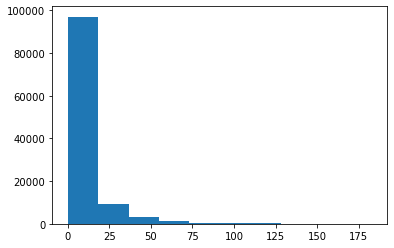

In [11]:
# Check follow up number data
plt.hist(all_xray_df['Follow-up #'])

In [12]:
all_xray_df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

Text(0, 0.5, 'Frequency')

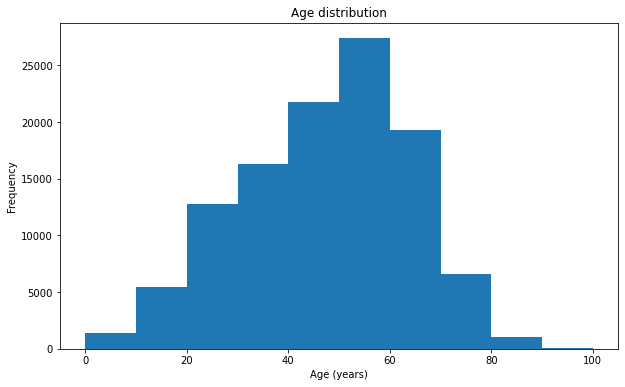

In [6]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], range=(0, 100))
plt.title('Age distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

Finding: Modal age range: 30-70.

In [13]:
# Unpack the disease labels from the 'Finding Labels' column
disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
disease_labels = [x for x in disease_labels if len(x)>0]
print('Disease Labels ({}): {}'.format(len(disease_labels), disease_labels))
for c_label in disease_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(10)

Disease Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6325,00001701_001.png,Infiltration,1,1701,38,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
54669,00013673_000.png,No Finding,0,13673,46,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9807,00002534_003.png,Atelectasis,3,2534,56,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6305,00001698_015.png,No Finding,15,1698,28,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
43156,00011140_005.png,Cardiomegaly|Effusion|Infiltration,5,11140,39,F,PA,2658,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82866,00020370_000.png,No Finding,0,20370,33,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52015,00013119_003.png,Atelectasis,3,13119,61,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97705,00025787_028.png,Effusion|Infiltration,28,25787,28,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73834,00018167_000.png,Infiltration,0,18167,44,F,PA,2530,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30202,00007872_002.png,Pleural_Thickening,2,7872,65,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
print ('Number of pneumonia cases :', all_xray_df['Pneumonia'].sum())

Number of pneumonia cases : 1430.0


In [15]:
print ('Number of non-pneumonia cases :', len(all_xray_df) - all_xray_df['Pneumonia'].sum())

Number of non-pneumonia cases : 110674.0


In [16]:
print('Percentage of pneumonia cases %:', all_xray_df['Pneumonia'].sum() * 100/len(all_xray_df))

Percentage of pneumonia cases %: 1.2756012274316706


Finding: This is an imbalanced dataset, so we will use 50-50% sampling for training, but actual real-world sampling for validation

Text(0.5, 1.0, 'Age distribution of patients with pneumonia')

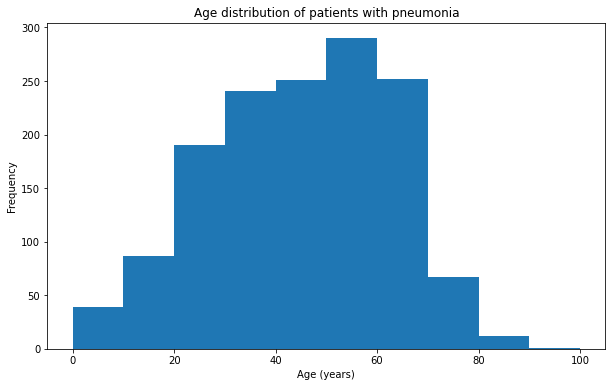

In [11]:
# Find age distribution for pneumonia patients
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Age'], range=(0, 100))
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age distribution of patients with pneumonia')

Finding: Most pneumonia data is from 30-70 years.

Text(0.5, 1.0, 'Pneumonia gender distribution')

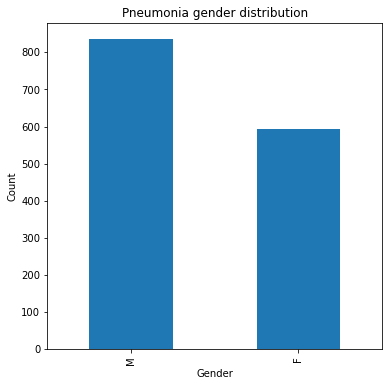

In [17]:
# Gender distribution of pneumonia patients
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Pneumonia gender distribution')

Finding: More males than females

In [18]:
# Proportion of diseases in our dataset
all_xray_df[disease_labels].sum() * 100/len(all_xray_df)

Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

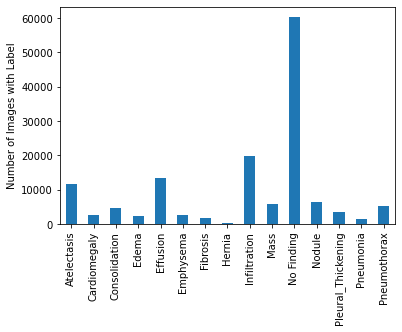

In [19]:
ax = all_xray_df[disease_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. It appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

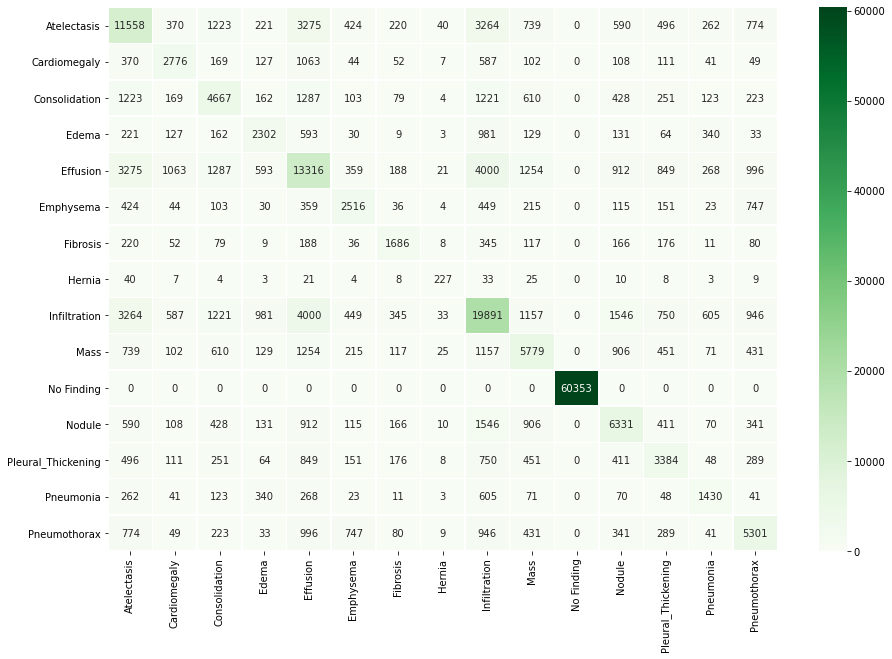

In [45]:
# Matrix plot of pneumonia with other diseases. We see that pneumonia co-occurs most frequently with infiltration
disease_labels_df = all_xray_df[disease_labels].astype(int)
coocc = disease_labels_df.T.dot(disease_labels_df)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(coocc, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="Greens")

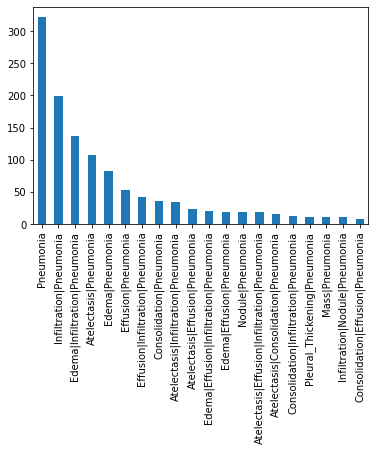

In [33]:
# Diseases comorbid with pneumonia. This will give combinations of diseases co-occuring with pneumonia
all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

In [21]:
# Percentage of cases where pneumonia and infiltration co-occur
len(all_xray_df[(all_xray_df.Pneumonia == 1) & (all_xray_df.Infiltration == 1)])/len(all_xray_df[(all_xray_df.Pneumonia == 1)]) * 100

42.30769230769231

**Finding: Nearly half the cases contain infiltration and pneumonia**

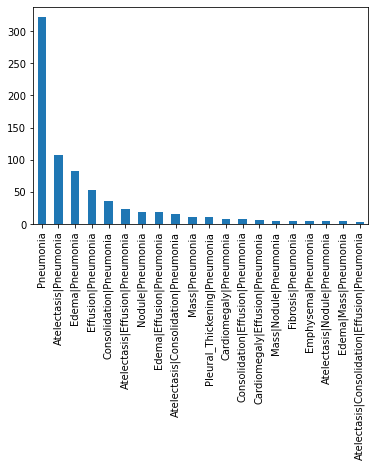

In [23]:
# Other top comorbidities for pneumonia besides Infiltration
all_xray_df[(all_xray_df.Pneumonia == 1) & (all_xray_df.Infiltration == 0)]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

In [24]:
# Diseases per patient
disease_labels_findings = list(disease_labels)
disease_labels_findings.remove('No Finding')
patient_disease_df = all_xray_df[['Patient ID'] + disease_labels_findings].groupby('Patient ID').agg('max')
patient_disease_df.head(20)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Patient ID,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Aggregate number of disease per patient
patient_disease_df["# Disease"] = patient_disease_df[disease_labels_findings].sum(axis=1).astype(int)

In [48]:
patient_disease_df.sort_values(by=['# Disease'], ascending=False)


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,# Disease
Patient ID,,,,,,,,,,,,,,,
16778,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13
12021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13
26451,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13
14022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13
12834,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Text(0.5, 1.0, 'Number of diseases per patient')

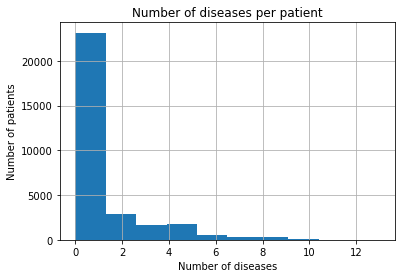

In [49]:
patient_disease_df.sort_values(by=['# Disease'], ascending=False)['# Disease'].hist(range=(0, 13))
plt.xlabel('Number of diseases')
plt.ylabel('Number of patients')
plt.title('Number of diseases per patient')

Text(0.5, 1.0, 'Number of diseases per patient')

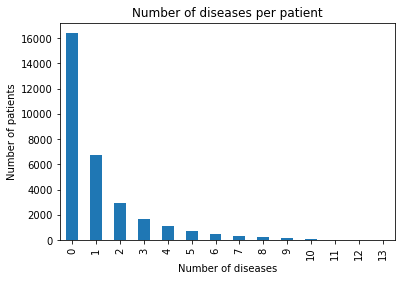

In [50]:
patient_disease_df.sort_values(by=['# Disease'], ascending=False)['# Disease'].value_counts().plot(kind='bar')
plt.xlabel('Number of diseases')
plt.ylabel('Number of patients')
plt.title('Number of diseases per patient')

In [51]:
# Finding: Majority of patients have no disease. Let's find out the percentage of patients that have disease
len(patient_disease_df[patient_disease_df["# Disease"] > 0]) * 100/len(patient_disease_df)

46.75345756769041

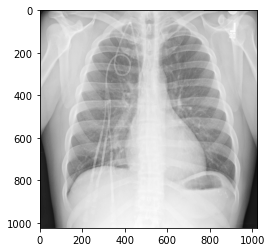

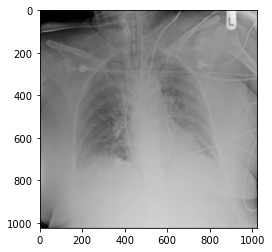

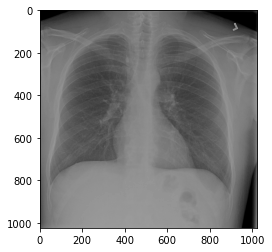

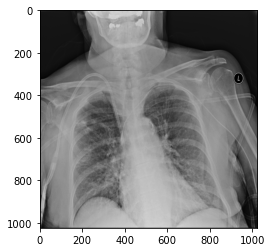

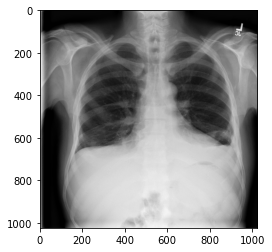

In [52]:
# Image level assessments
# Look at a random sample of images to get an idea
sample5 = sample_df.sample(5)
i = 0
for imgName in sample5['path']:
    plt.figure(i)
    imgArray = plt.imread(imgName)
    plt.imshow(imgArray, cmap='gray')
    i += 1
    

In [53]:
# Unpack the disease labels from the 'Finding Labels' column
sample_disease_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_disease_labels = [x for x in sample_disease_labels if len(x)>0]
for c_label in sample_disease_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4216,00020703_009.png,Effusion|Infiltration|Mass|Nodule,9,20703,061Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2924,00014387_013.png,No Finding,13,14387,035Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3015,00014826_004.png,No Finding,4,14826,016Y,F,PA,2990,2674,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5094,00027073_000.png,No Finding,0,27073,007Y,F,PA,2378,2153,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3381,00016672_003.png,Atelectasis|Effusion|Hernia|Infiltration,3,16672,075Y,M,PA,2716,2642,0.143000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5206,00027784_008.png,No Finding,8,27784,040Y,M,PA,2020,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4602,00022993_015.png,No Finding,15,22993,055Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1553,00008051_012.png,No Finding,12,8051,049Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
606,00003122_015.png,No Finding,15,3122,057Y,M,PA,2990,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
322,00001698_004.png,Atelectasis,4,1698,028Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
def get_intensity_metrics(df_imagefiles):
    all_intensities = []
    for imgName in df_imagefiles:
        imgArray = io.imread(imgName, as_gray=True)
        all_intensities.append(np.ravel(imgArray))

    all_intensities = list(chain(*all_intensities))

    mean_intensity = np.mean(all_intensities)
    std_intensity = np.std(all_intensities)
    return all_intensities, mean_intensity, std_intensity


Text(0, 0.5, '# Pixels in Image')

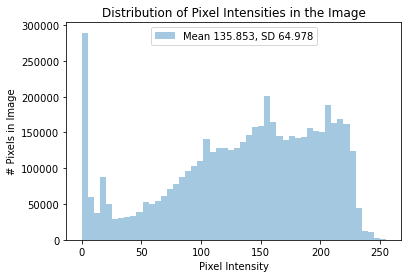

In [55]:
# Pneumonia
pneumonia_intensities, pneumonia_mean, pneumonia_std = get_intensity_metrics(sample_df[sample_df.Pneumonia == 1]['path'].sample(n=5, random_state=1))

sns.distplot(pneumonia_intensities, 
             label=f'Mean {pneumonia_mean:.3f}, SD {pneumonia_std:.3f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Text(0, 0.5, '# Pixels in Image')

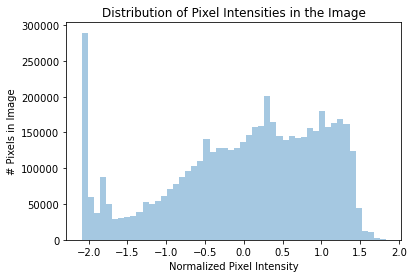

In [56]:
pneumonia_intensities_normal = (pneumonia_intensities - pneumonia_mean)/pneumonia_std

sns.distplot(pneumonia_intensities_normal, kde=False)
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('# Pixels in Image')


Text(0, 0.5, '# Pixels in Image')

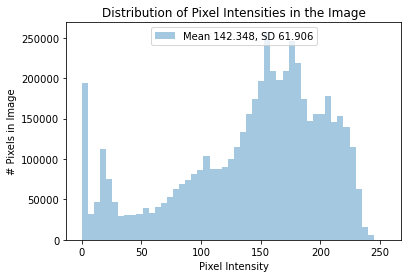

In [57]:
# Non-Pneumonia
non_pneumonia_intensities, non_pneumonia_mean, non_pneumonia_std = get_intensity_metrics(sample_df[sample_df.Pneumonia == 0]['path'].sample(n=5, random_state=1))

sns.distplot(non_pneumonia_intensities, 
             label=f'Mean {non_pneumonia_mean:.3f}, SD {non_pneumonia_std:.3f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Text(0, 0.5, '# Pixels in Image')

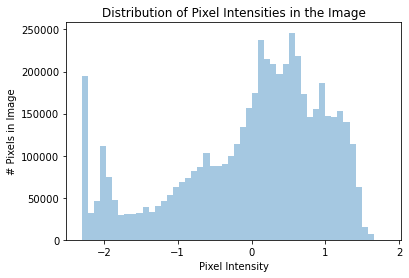

In [58]:
non_pneumonia_intensities_normal = (non_pneumonia_intensities - non_pneumonia_mean)/non_pneumonia_std

sns.distplot(non_pneumonia_intensities_normal, kde=False)
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')


Text(0, 0.5, '# Pixel')

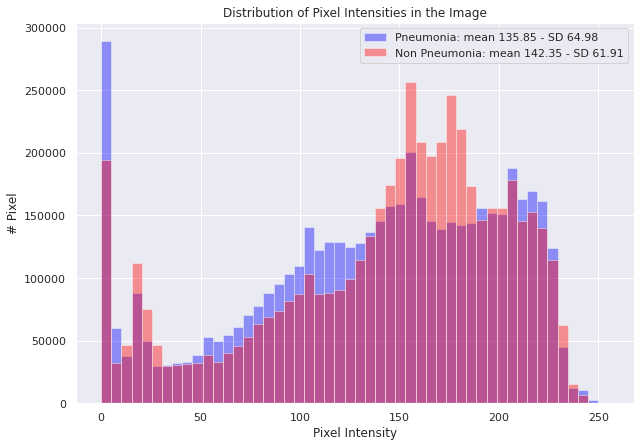

In [59]:
# Overlay the distribution of the actual pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for pneumonia
sns.distplot(pneumonia_intensities, 
             label=f'Pneumonia: mean {pneumonia_mean:.2f} - SD {pneumonia_std:.2f}',
             color='blue', 
             kde=False)

# Plot histogram for non-pneumonia
sns.distplot(non_pneumonia_intensities, 
             label=f'Non Pneumonia: mean {non_pneumonia_mean:.2f} - SD {non_pneumonia_std:.2f}',
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

Text(0, 0.5, '# Pixel')

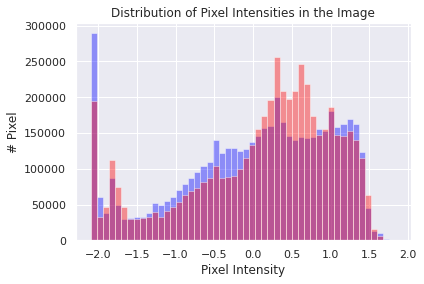

In [60]:
# Overlay normalized non-pneumonia pixel distribution based on pneumonia
non_pneumonia_intensities_normal = (non_pneumonia_intensities - pneumonia_mean)/pneumonia_std

# Plot histogram for pneumonia
sns.distplot(pneumonia_intensities_normal,
             color='blue', 
             kde=False)

# Plot histogram for non-pneumonia
sns.distplot(non_pneumonia_intensities_normal, 
             color='red', 
             kde=False)

# Place legends
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

Finding: Non-pneumonia intensity values when normalized according to pneumonia, mostly fall within 1.5 standard deviations.
Therefore intensity level thresholding by itself would not work

Text(0, 0.5, '# Pixel')

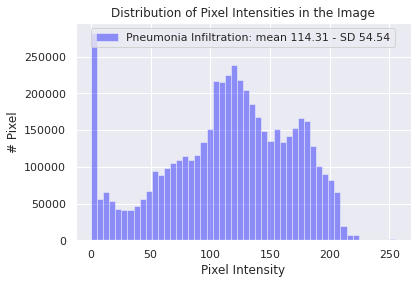

In [61]:
# Plot image intensities with pneumonia and infiltration. This is approximately half of all pneumonia cases
pneumonia_infil_intensities, pneumonia_infil_mean, pneumonia_infil_std = get_intensity_metrics(sample_df[(sample_df.Pneumonia == 1) & (sample_df.Infiltration == 1)]['path'].sample(n=5, random_state=1))

sns.distplot(pneumonia_infil_intensities, 
             label=f'Pneumonia Infiltration: mean {pneumonia_infil_mean:.2f} - SD {pneumonia_infil_std:.2f}',
             color='blue', 
             kde=False)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

Text(0, 0.5, '# Pixel')

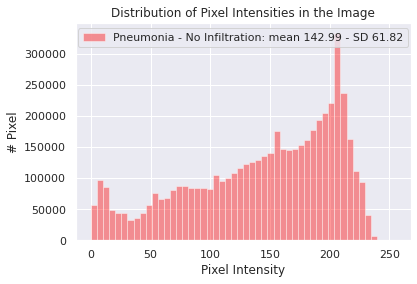

In [62]:
# Plot image intensities with pneumonia without infiltration. This is approximately half of all pneumonia cases
pneumonia_noinfil_intensities, pneumonia_noinfil_mean, pneumonia_noinfil_std = get_intensity_metrics(sample_df[(sample_df.Pneumonia == 1) & (sample_df.Infiltration == 0)]['path'].sample(n=5, random_state=1))

sns.distplot(pneumonia_noinfil_intensities, 
             label=f'Pneumonia - No Infiltration: mean {pneumonia_noinfil_mean:.2f} - SD {pneumonia_noinfil_std:.2f}',
             color='red', 
             kde=False)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

Finding: The mean intensities of pneumonia with and without infiltration are considerably different.
Once we are able to successfully classify pneumonia vs. non-pneumonia, we may be able to use that model to create a second model to predict infiltration vs non-filtration

Text(0, 0.5, '# Pixel')

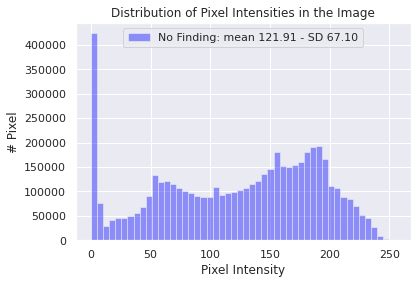

In [63]:
# Plot image intensities for No Finding. This is just over half of all cases
pneumonia_nofind_intensities, pneumonia_nofind_mean, pneumonia_nofind_std = get_intensity_metrics(sample_df[sample_df['No Finding'] == 1]['path'].sample(n=5, random_state=1))

sns.distplot(pneumonia_nofind_intensities, 
             label=f'No Finding: mean {pneumonia_nofind_mean:.2f} - SD {pneumonia_nofind_std:.2f}',
             color='blue', 
             kde=False)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

These are low intensities overall but higher than cases with infiltration

Text(0, 0.5, '# Pixel')

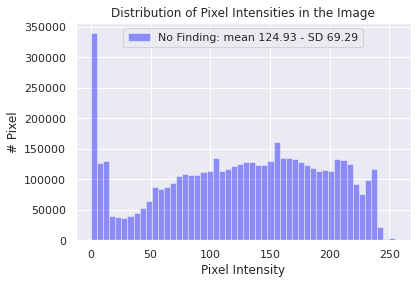

In [65]:
# Plot image intensities for Effusion
effusion_intensities, effusion_mean, effusion_std = get_intensity_metrics(sample_df[sample_df['Effusion'] == 1]['path'].sample(n=5, random_state=1))

sns.distplot(effusion_intensities, 
             label=f'No Finding: mean {effusion_mean:.2f} - SD {effusion_std:.2f}',
             color='blue', 
             kde=False)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

Text(0, 0.5, '# Pixel')

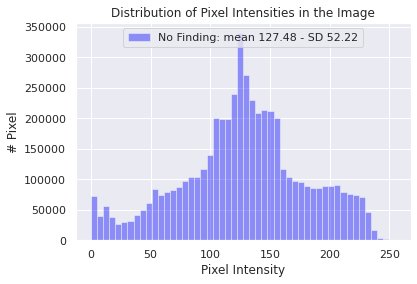

In [66]:
# Plot image intensities for Atelectasis
atel_intensities, atel_mean, atel_std = get_intensity_metrics(sample_df[sample_df['Atelectasis'] == 1]['path'].sample(n=5, random_state=1))

sns.distplot(atel_intensities, 
             label=f'No Finding: mean {atel_mean:.2f} - SD {atel_std:.2f}',
             color='blue', 
             kde=False)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

In [67]:
stats.ttest_ind(pneumonia_intensities, non_pneumonia_intensities)

Ttest_indResult(statistic=-165.70555556210957, pvalue=0.0)

In [68]:
stats.ttest_ind(pneumonia_infil_intensities, pneumonia_noinfil_intensities)

Ttest_indResult(statistic=-796.6287407936419, pvalue=0.0)

Finding: The two differences above are statistically significant. So we can conclude that it should be possible for pneumonia to be distinguished from non-pneumonia X-rays based on image intensities.